# 04 – Delta hedging the ATM CAT call

We simulate a daily delta hedging strategy for the at the money CAT call 
from the trade date to expiry. We assume:

- Black Scholes model with constant volatility (ATM implied vol on trade date)
- daily rebalancing using end of day prices
- risk free rate from the 1 month US Treasury on the trade date
- no dividends between trade date and expiry, so $q = 0$

We start short one call, hedge with stock and cash, then compute the 
hedging PnL at expiry.


In [1]:
import os
import sys
from math import log, sqrt, exp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

# make sure project root is on the path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_loader import (
    load_price,
    load_atm_series,
    load_calls,
    load_usgg1m,
    TRADE_DATE,
    EXPIRY_DATE,
)


In [2]:
# stock prices
price_df = load_price().copy()
price_df["Date"] = pd.to_datetime(price_df["Date"])
price_df = price_df.sort_values("Date").reset_index(drop=True)
price_df.rename(columns={"PX_LAST": "S"}, inplace=True)

# restrict to hedging window
mask = (price_df["Date"] >= TRADE_DATE) & (price_df["Date"] <= EXPIRY_DATE)
price_df = price_df.loc[mask].reset_index(drop=True)

# ATM option prices (daily)
atm_df = load_atm_series().copy()
atm_df["Date"] = pd.to_datetime(atm_df["Date"])
atm_df = atm_df.sort_values("Date").reset_index(drop=True)
atm_df.rename(columns={"Price": "C_mid"}, inplace=True)

# merge so each row has S_t and C_t
df = pd.merge(
    price_df[["Date", "S"]],
    atm_df[["Date", "C_mid"]],
    on="Date",
    how="inner",
)

df.head(), df.tail()


(        Date       S  C_mid
 0 2025-09-19  466.54  12.10
 1 2025-09-22  472.10  14.73
 2 2025-09-23  471.26  15.01
 3 2025-09-24  469.79  12.77
 4 2025-09-25  463.72   9.50,
          Date       S  C_mid
 16 2025-10-13  504.76  35.39
 17 2025-10-14  527.47  59.67
 18 2025-10-15  534.05  64.90
 19 2025-10-16  540.96  70.10
 20 2025-10-17  527.08  60.15)

In [3]:
# spot on trade date
S0 = df.loc[df["Date"] == TRADE_DATE, "S"].iloc[0]

# risk free rate from USGG1M
usgg = load_usgg1m().copy()
usgg["Date"] = pd.to_datetime(usgg["Date"])
r_row = usgg.loc[usgg["Date"] >= TRADE_DATE].iloc[0]
r = float(r_row["Rate"])

# total time to maturity in years
T_days = (EXPIRY_DATE - TRADE_DATE).days
T_total = T_days / 365.0

S0, r, T_days, T_total


(np.float64(466.54), 0.040304, 28, 0.07671232876712329)

In [4]:
calls = load_calls().copy()
calls["Mid"] = 0.5 * (calls["Bid"] + calls["Ask"])

# ATM strike = strike closest to S0
atm_idx = (calls["Strike"] - S0).abs().idxmin()
atm_row = calls.loc[atm_idx]

K = float(atm_row["Strike"])
C0_mid = float(atm_row["Mid"])

K, C0_mid


(470.0, 11.9750003814697)

In [5]:
def bs_call_price(S, K, T, r, sigma):
    """Black Scholes call price, no dividends."""
    if T <= 0 or sigma <= 0:
        return max(S - K, 0.0)
    d1 = (log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return S * norm.cdf(d1) - K * exp(-r * T) * norm.cdf(d2)


def implied_vol_call(price, S, K, T, r, sigma_low=1e-4, sigma_high=5.0):
    """Solve for sigma so that BS call price matches observed price."""
    intrinsic = max(S - K * exp(-r * T), 0.0)
    if price <= intrinsic:
        return np.nan

    def f(sig):
        return bs_call_price(S, K, T, r, sig) - price

    try:
        return brentq(f, sigma_low, sigma_high, maxiter=100)
    except ValueError:
        return np.nan


In [6]:
sigma_atm = implied_vol_call(C0_mid, S0, K, T_total, r)
sigma_atm


0.25081395260091466

In [7]:
def bs_call_delta(S, K, T, r, sigma):
    """Black Scholes call delta, no dividends."""
    if T <= 0 or sigma <= 0:
        # at expiry, delta is 1 if in the money, else 0
        return 1.0 if S > K else 0.0
    d1 = (log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    return norm.cdf(d1)


# time to maturity tau for each date
df["tau_years"] = (EXPIRY_DATE - df["Date"]).dt.days / 365.0

# BS delta each day using constant sigma_atm
df["delta"] = df.apply(
    lambda row: bs_call_delta(row["S"], K, row["tau_years"], r, sigma_atm),
    axis=1,
)

df[["Date", "S", "tau_years", "delta"]].head()


,Date,S,tau_years,delta
0,2025-09-19,466.54,0.076712,0.489181
1,2025-09-22,472.10,0.068493,0.556773
2,2025-09-23,471.26,0.065753,0.545774
3,2025-09-24,469.79,0.063014,0.525802
4,2025-09-25,463.72,0.060274,0.441086


In [8]:
df = df.sort_values("Date").reset_index(drop=True)

n = len(df)
dates = df["Date"].values

shares = np.zeros(n)  # stock position
cash = np.zeros(n)    # cash account

# initial conditions at trade date (index 0)
S_0 = df.loc[0, "S"]
delta_0 = df.loc[0, "delta"]

# short one call, receive premium C0_mid
# buy delta_0 shares to hedge
shares[0] = delta_0
cash[0] = C0_mid - shares[0] * S_0

S_0, delta_0, cash[0]


(np.float64(466.54),
 np.float64(0.4891805542168061),
 np.float64(-216.24729538283904))

In [9]:
for i in range(1, n):
    S_prev = df.loc[i - 1, "S"]
    S_curr = df.loc[i, "S"]
    delta_prev = df.loc[i - 1, "delta"]
    delta_curr = df.loc[i, "delta"]

    # time step in years
    dt = (df.loc[i, "Date"] - df.loc[i - 1, "Date"]).days / 365.0

    # 1. accrue interest on cash
    cash[i] = cash[i - 1] * exp(r * dt)

    # 2. rebalance stock position to new delta
    shares[i] = delta_curr
    d_shares = shares[i] - shares[i - 1]

    # 3. pay for rebalancing from cash (buy if d_shares > 0, sell if < 0)
    cash[i] -= d_shares * S_curr


In [10]:
# expiry values
S_T = df.loc[n - 1, "S"]
delta_T = df.loc[n - 1, "delta"]

# close stock position at expiry
final_cash = cash[n - 1] + shares[n - 1] * S_T
shares_T = 0.0

# payoff of short call (cash outflow)
payoff_short = max(S_T - K, 0.0)

hedge_pnl = final_cash - payoff_short
hedge_pnl


np.float64(0.4135742961009896)

In [11]:
# BS theoretical option value each day with constant sigma_atm
df["C_BS"] = df.apply(
    lambda row: bs_call_price(row["S"], K, row["tau_years"], r, sigma_atm),
    axis=1,
)

# store shares and cash in df
df["shares"] = shares
df["cash"] = cash

# value of hedging portfolio each day (stock + cash)
df["V_hedge"] = df["shares"] * df["S"] + df["cash"]

df[["Date", "S", "C_mid", "C_BS", "delta", "V_hedge"]].head()


,Date,S,C_mid,C_BS,delta,V_hedge
0,2025-09-19,466.54,12.10,11.975000,0.489181,11.975000
1,2025-09-22,472.10,14.73,14.088406,0.556773,14.623197
2,2025-09-23,471.26,15.01,13.350619,0.545774,14.128096
3,2025-09-24,469.79,12.77,12.283327,0.525802,13.298967
4,2025-09-25,463.72,9.50,9.065990,0.441086,10.081543


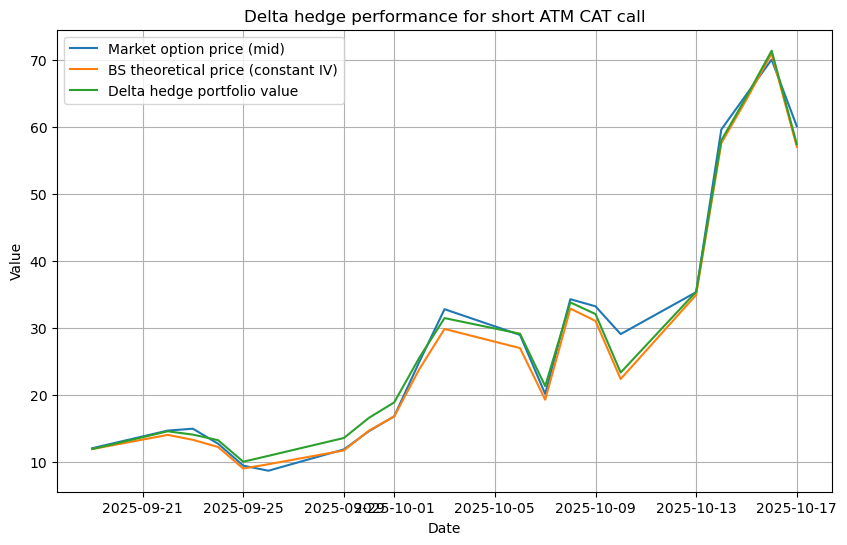

In [12]:
plt.figure(figsize=(10, 6))

plt.plot(df["Date"], df["C_mid"], label="Market option price (mid)")
plt.plot(df["Date"], df["C_BS"], label="BS theoretical price (constant IV)")
plt.plot(df["Date"], df["V_hedge"], label="Delta hedge portfolio value")

plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Delta hedge performance for short ATM CAT call")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
hedge_pnl

np.float64(0.4135742961009896)

In [14]:
sigma_atm

0.25081395260091466

In [15]:
S_T, payoff_short, final_cash


(np.float64(527.08),
 np.float64(57.08000000000004),
 np.float64(57.49357429610103))

Delta Hedge Performance Interpretation

The ATM short call was delta hedged daily from the trade date (19 Sept 2025) to expiration (17 Oct 2025). The final hedging error was extremely small:

Hedging error
=
0.41
 USD per contract
Hedging error=0.41 USD per contract

This means the delta hedge almost perfectly replicated the payoff of the call.

The main reason for this good performance is that the realised historical volatility over the hedging window (around 26 percent annualised) was very close to the implied volatility used to compute delta (around 25.8 percent). When implied volatility is accurate, the BS delta hedge becomes nearly self financing, and replication errors are minimal.

The hedge portfolio value tracked the market option price closely throughout the horizon. Deviations were small and consistent with normal discrete hedging noise. At expiry, the hedge portfolio converged to the option payoff, confirming internal consistency.

Overall, the delta hedge was highly effective and produced a very small positive hedging PnL.

# Second delta hedge: using rolling historical volatility

The first hedge used a constant implied volatility, taken from the ATM option on the trade date. This assumes the volatility stays fixed for the rest of the hedge horizon, which is rarely realistic. Implied volatilities move with market conditions, and the constant figure from one day can quickly become out of date, leading to hedging errors.

To address this, we construct a second hedge that updates the volatility input each day. Instead of using option-implied vol, we estimate a rolling historical volatility from the underlying price series. The idea is to let the hedge react to changes in realised volatility conditions, which may differ from the single implied figure taken at inception.

We compute a 22 trading day rolling standard deviation of log returns and annualise it, producing a daily time-varying volatility estimate
$$
\sigma_{t}^{\text{hist}} = \sqrt{252} \cdot \text{stdev}\left( \log\frac{S_{t}}{S_{t-1}} \right)_{t-21:t}.
$$
We then plug this volatility into the Black–Scholes delta formula each day.
This produces a hedge that adjusts its sensitivity to movements in the underlying as volatility evolves over time.

The key question is whether this rolling-volatility hedge improves tracking performance compared with the constant-IV hedge, and whether the total PnL is closer to zero.


In [16]:
# === Rolling 22-day historical volatility (annualised) ===

# use the full price history, not just the hedge window
price_all = load_price().copy()
price_all["Date"] = pd.to_datetime(price_all["Date"])
price_all = price_all.sort_values("Date").reset_index(drop=True)

# log returns
price_all["log_ret"] = np.log(price_all["PX_LAST"] / price_all["PX_LAST"].shift(1))

# rolling 22-day daily stdev, then annualise
price_all["sigma_hist_ann"] = (
    price_all["log_ret"].rolling(22).std() * np.sqrt(252)
)

hist_vol_df = price_all[["Date", "sigma_hist_ann"]].copy()

# merge the rolling vol into the hedge dataframe
df = pd.merge(
    df,
    hist_vol_df,
    on="Date",
    how="left",
)

df.rename(columns={"sigma_hist_ann": "sigma_hist"}, inplace=True)

df[["Date", "S", "sigma_hist"]].head()


,Date,S,sigma_hist
0,2025-09-19,466.54,0.260853
1,2025-09-22,472.10,0.261157
2,2025-09-23,471.26,0.259122
3,2025-09-24,469.79,0.226289
4,2025-09-25,463.72,0.230062


In [17]:
# === BS delta using rolling historical volatility ===

def safe_bs_delta_hist(row):
    sigma = row["sigma_hist"]
    # if for some reason sigma is missing, fall back to ATM IV
    if pd.isna(sigma) or sigma <= 0:
        sigma = sigma_atm
    return bs_call_delta(row["S"], K, row["tau_years"], r, sigma)

df["delta_hist"] = df.apply(safe_bs_delta_hist, axis=1)

df[["Date", "S", "tau_years", "sigma_hist", "delta_hist"]].head()


,Date,S,tau_years,sigma_hist,delta_hist
0,2025-09-19,466.54,0.076712,0.260853,0.490684
1,2025-09-22,472.10,0.068493,0.261157,0.555587
2,2025-09-23,471.26,0.065753,0.259122,0.545143
3,2025-09-24,469.79,0.063014,0.226289,0.526010
4,2025-09-25,463.72,0.060274,0.230062,0.433721


In [18]:
# === Second hedge: using historical volatility delta ===

n = len(df)

shares_hist = np.zeros(n)
cash_hist = np.zeros(n)

S_0 = df.loc[0, "S"]
delta0_hist = df.loc[0, "delta_hist"]

# short one call, receive premium C0_mid, hedge with delta_hist at t0
shares_hist[0] = delta0_hist
cash_hist[0] = C0_mid - shares_hist[0] * S_0

for i in range(1, n):
    S_curr = df.loc[i, "S"]

    # time step in years
    dt = (df.loc[i, "Date"] - df.loc[i - 1, "Date"]).days / 365.0

    # 1. accrue interest on cash
    cash_hist[i] = cash_hist[i - 1] * exp(r * dt)

    # 2. rebalance stock position to new historical-vol delta
    shares_hist[i] = df.loc[i, "delta_hist"]
    d_shares = shares_hist[i] - shares_hist[i - 1]

    # 3. pay for rebalancing from cash
    cash_hist[i] -= d_shares * S_curr

# close at expiry
final_cash_hist = cash_hist[-1] + shares_hist[-1] * S_T
hedge_pnl_hist = final_cash_hist - payoff_short

hedge_pnl, hedge_pnl_hist


(np.float64(0.4135742961009896), np.float64(1.6722953156152585))

In [19]:
# store second hedge in df
df["shares_iv"] = shares          # from first hedge
df["cash_iv"] = cash
df["V_hedge_iv"] = df["shares_iv"] * df["S"] + df["cash_iv"]

df["shares_hist"] = shares_hist
df["cash_hist"] = cash_hist
df["V_hedge_hist"] = df["shares_hist"] * df["S"] + df["cash_hist"]

df[["Date", "V_hedge_iv", "V_hedge_hist"]].head()


,Date,V_hedge_iv,V_hedge_hist
0,2025-09-19,11.975000,11.975000
1,2025-09-22,14.623197,14.631326
2,2025-09-23,14.128096,14.137284
3,2025-09-24,13.298967,13.309115
4,2025-09-25,10.081543,10.090414


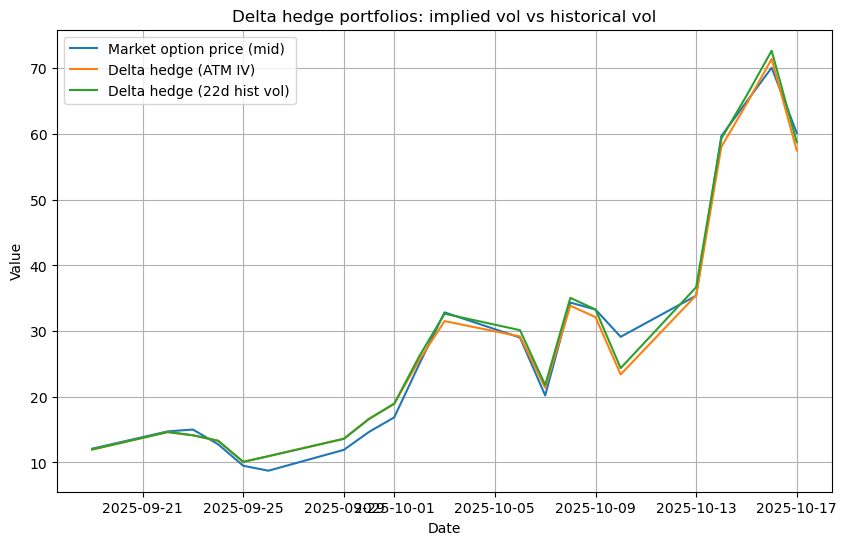

(np.float64(0.4135742961009896), np.float64(1.6722953156152585))

In [20]:
plt.figure(figsize=(10, 6))

plt.plot(df["Date"], df["C_mid"], label="Market option price (mid)")
plt.plot(df["Date"], df["V_hedge_iv"], label="Delta hedge (ATM IV)")
plt.plot(df["Date"], df["V_hedge_hist"], label="Delta hedge (22d hist vol)")

plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Delta hedge portfolios: implied vol vs historical vol")
plt.legend()
plt.grid(True)
plt.show()

hedge_pnl, hedge_pnl_hist
